# SM2 — Summer Behavior Profile (Apartments, Corridors, Garages) + Thermal Accumulation

This notebook summarizes the **typical summer behavior** of the SM2 complex, combining **Atrea** and **ThermoPro** data.

## Objectives
1. **Typical summer day** profile in:
   - **Apartments** (Atrea `temp_indoor` as indoor proxy)
   - **Corridors** (ThermoPro `temp_indoor`, focus on **5NP** staircase corridors)
   - **Garages** (ThermoPro `temp_indoor`, floors **1PP/2PP/3PP**)
2. If multiple corridor/garage **typical profiles** exist, show each.
3. Show **thermal accumulation/inertia**: indoor temps build up and cool down slowly versus outside air.

### Data notes
- `temp_*` in °C, `humidity_*` in %.
- Times are in UTC in the raw dataset; we convert to **Europe/Prague** for daily/hourly profiles.
- Plots use **matplotlib** (one chart per figure, no explicit colors).


In [1]:
try:
    import pandas as pd
    import matplotlib
except Exception:
    %pip install -q pandas pyarrow matplotlib gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os, re

plt.rcParams['figure.figsize'] = (12, 6)
OUT_DIR = Path('outputs'); OUT_DIR.mkdir(exist_ok=True)


## Download & load dataset (Parquet preferred)

In [2]:
PARQUET_ID = "1gLPWgUGtRb371Gpv5O8t5j95lthNjELg"  # sm2_public_dataset.parquet
CSVGZ_ID  = "1eLOAOZ13--EKE63GZhmerjmY9zkeJcyd"  # sm2_public_dataset.csv.gz
USE_PARQUET = True

parquet_path = Path('sm2_public_dataset.parquet')
csvgz_path   = Path('sm2_public_dataset.csv.gz')

def gdown_download(file_id: str, out_path: Path):
    import subprocess, sys
    try:
        import gdown  # type: ignore
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'gdown'])
        import gdown  # type: ignore
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, str(out_path), quiet=False)

if USE_PARQUET:
    if not parquet_path.exists():
        print('Downloading Parquet…')
        gdown_download(PARQUET_ID, parquet_path)
else:
    if not csvgz_path.exists():
        print('Downloading CSV.GZ…')
        gdown_download(CSVGZ_ID, csvgz_path)

if USE_PARQUET and parquet_path.exists():
    df = pd.read_parquet(parquet_path)
elif csvgz_path.exists():
    df = pd.read_csv(csvgz_path, compression='gzip')
else:
    raise FileNotFoundError('Dataset not found. Check IDs or internet access.')

df['time'] = pd.to_datetime(df['time'], utc=True, errors='coerce')
df['data_value'] = pd.to_numeric(df['data_value'], errors='coerce')
print('Shape:', df.shape)
df.head(3)


Downloading...
From: https://drive.google.com/uc?id=1gLPWgUGtRb371Gpv5O8t5j95lthNjELg
To: /content/sm2_public_dataset.parquet
100%|██████████| 1.29M/1.29M [00:00<00:00, 56.8MB/s]


Shape: (651332, 6)


,time,location,source,measurement,data_key,data_value
0,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_ambient,4.0
1,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_fresh,20.3
2,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_indoor,21.4


## Helpers: location parsing & summer windows

- Summer window: **June 1 – Aug 31** (inclusive) in **Europe/Prague**.
- We will use **2024** and **2025**; some charts aggregate both years for a smoother "typical" profile.

In [3]:
def parse_location(loc: str):
    if isinstance(loc, str) and loc.startswith('sm2_'):
        try:
            sec_num = int(loc.split('_')[-1])
        except Exception:
            sec_num = None
        return {'is_atrea': True, 'floor_code': None, 'section_num': sec_num}
    m = re.match(r"^(?P<floor>\d[NP]P?)-S(?P<section>\d+)$", str(loc))
    if m:
        return {'is_atrea': False,
                'floor_code': m.group('floor'),
                'section_num': int(m.group('section'))}
    return {'is_atrea': None, 'floor_code': None, 'section_num': None}

df['local_time'] = df['time'].dt.tz_convert('Europe/Prague')
df['local_day'] = df['local_time'].dt.floor('D')
df['year'] = df['local_time'].dt.year

SUMMER_START = {2024: pd.Timestamp('2024-06-01', tz='Europe/Prague'), 2025: pd.Timestamp('2025-06-01', tz='Europe/Prague')}
SUMMER_END   = {2024: pd.Timestamp('2024-08-31', tz='Europe/Prague'), 2025: pd.Timestamp('2025-08-31', tz='Europe/Prague')}

loc_meta = df['location'].drop_duplicates().to_frame()
loc_meta = pd.concat([loc_meta, loc_meta['location'].map(parse_location).apply(pd.Series)], axis=1)
loc_meta.head(10)


,location,is_atrea,floor_code,section_num
0,sm2_01,True,None,1
5,sm2_02,True,None,2
10,sm2_03,True,None,3
15,sm2_04,True,None,4
20,sm2_05,True,None,5
25,sm2_06,True,None,6
30,sm2_07,True,None,7
35,sm2_08,True,None,8
40,sm2_09,True,None,9
551373,1PP-S1,False,1PP,1


## Part A — Typical summer day in **apartments** (Atrea)

- Use `Atrea` **`temp_indoor`** as apartment indoor proxy.
- Compute **mean hour-of-day profile** across summers 2024 & 2025 (Europe/Prague).
- Also overlay mean hour-of-day for **`temp_fresh`** (supply air) and **`temp_ambient`** (outdoor reference).

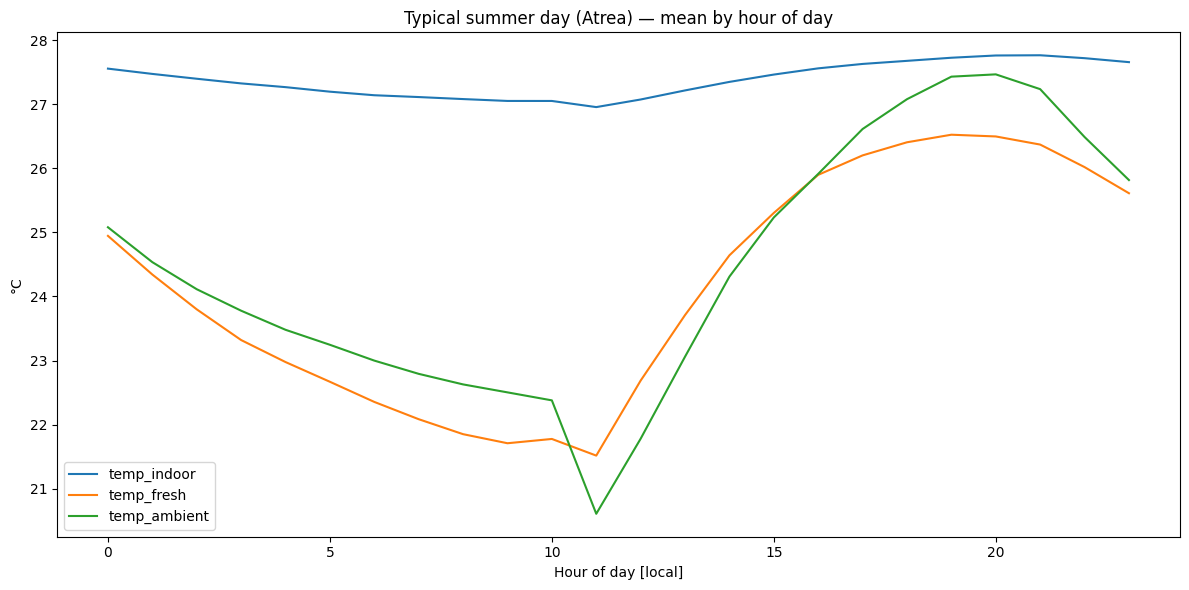

Saved: outputs/profile_atrea_typical_day.png


In [4]:
atrea = df[df['source']=='Atrea'].copy()
mask_summer = ((atrea['year']==2024) & (atrea['local_day']>=SUMMER_START[2024]) & (atrea['local_day']<=SUMMER_END[2024])) | \
              ((atrea['year']==2025) & (atrea['local_day']>=SUMMER_START[2025]) & (atrea['local_day']<=SUMMER_END[2025]))
summer_atrea = atrea[mask_summer].copy()
summer_atrea['hod'] = summer_atrea['local_time'].dt.hour

def hod_mean(frame, key):
    sub = frame[frame['data_key']==key]
    if sub.empty:
        return None
    return sub.groupby('hod')['data_value'].mean().reset_index(name=key)

m_indoor = hod_mean(summer_atrea, 'temp_indoor')
m_fresh  = hod_mean(summer_atrea, 'temp_fresh')
m_amb    = hod_mean(summer_atrea, 'temp_ambient')

merged = None
for m in [m_indoor, m_fresh, m_amb]:
    if m is None: continue
    merged = m if merged is None else pd.merge(merged, m, on='hod', how='outer')

if merged is None or merged.empty:
    print('No Atrea summer data to plot.')
else:
    fig = plt.figure()
    ax = plt.gca()
    if 'temp_indoor' in merged.columns:
        ax.plot(merged['hod'], merged['temp_indoor'], label='temp_indoor')
    if 'temp_fresh' in merged.columns:
        ax.plot(merged['hod'], merged['temp_fresh'], label='temp_fresh')
    if 'temp_ambient' in merged.columns:
        ax.plot(merged['hod'], merged['temp_ambient'], label='temp_ambient')
    ax.set_title('Typical summer day (Atrea) — mean by hour of day')
    ax.set_xlabel('Hour of day [local]')
    ax.set_ylabel('°C')
    ax.legend()
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'profile_atrea_typical_day.png', dpi=150)
    plt.show()
    print('Saved:', OUT_DIR / 'profile_atrea_typical_day.png')


## Part B — Typical summer day in **corridors** (5NP, ThermoPro)

- Focus on **5NP**: `location` like `5NP-S*`.
- Compute **mean hour-of-day** per section.
- Identify **multiple typical profiles** by splitting sections into **cooler / medium / hotter** bins (by their average across the day).

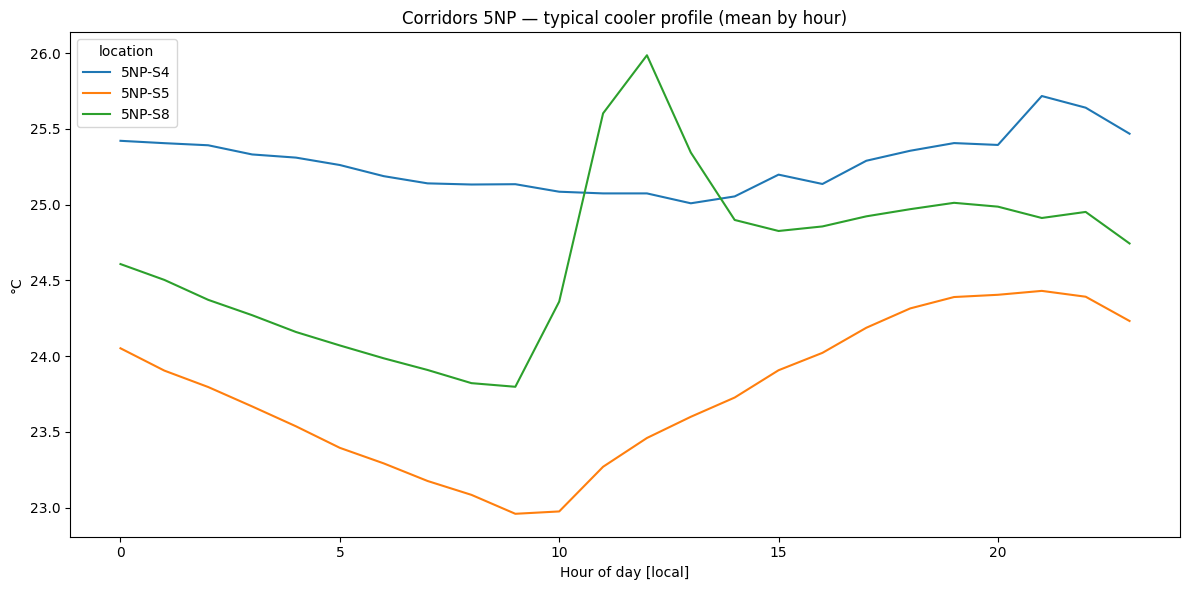

Saved: outputs/profile_corridors_5NP_cooler.png


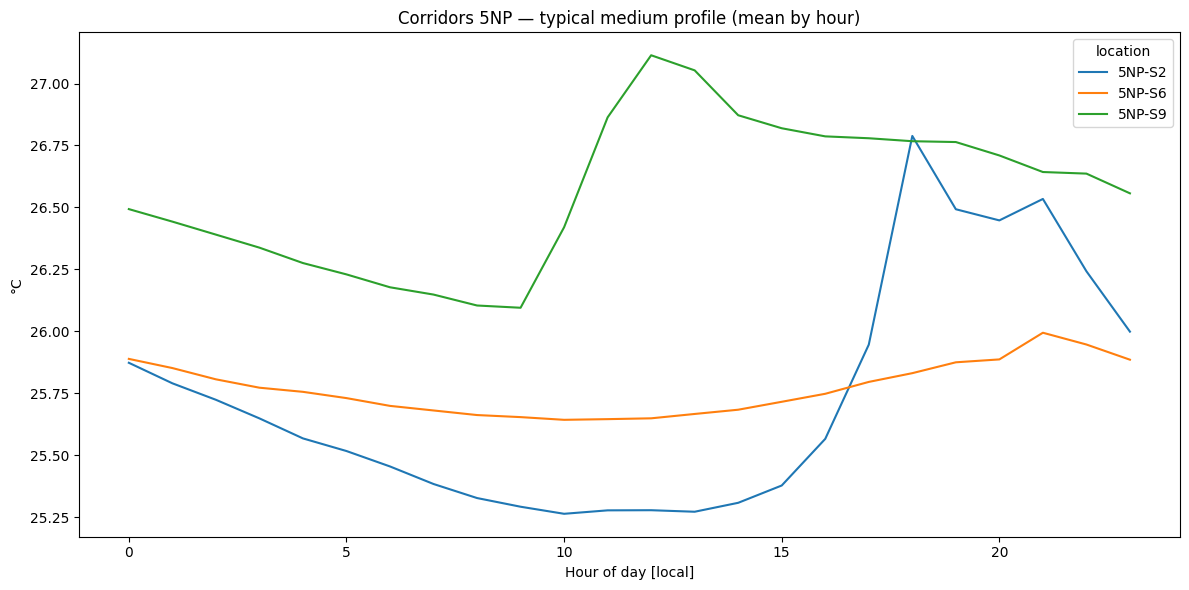

Saved: outputs/profile_corridors_5NP_medium.png


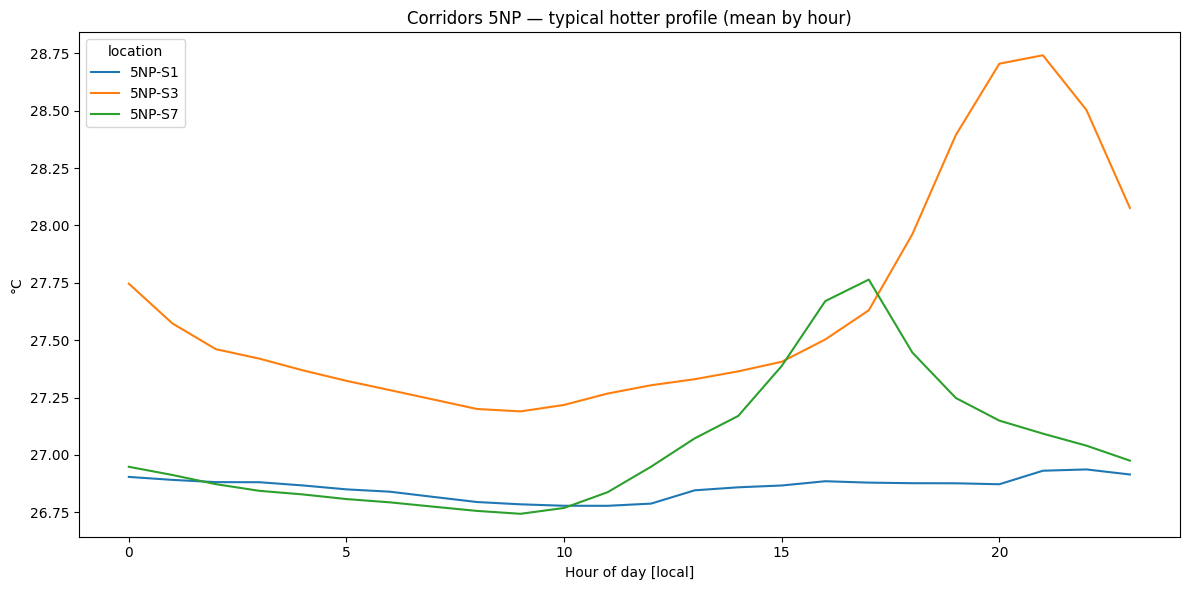

Saved: outputs/profile_corridors_5NP_hotter.png


In [5]:
tp = df[(df['source']=='ThermoPro') & (df['data_key']=='temp_indoor')].copy()
tp['hod'] = tp['local_time'].dt.hour
tp_summer = tp[((tp['year']==2024) & (tp['local_day']>=SUMMER_START[2024]) & (tp['local_day']<=SUMMER_END[2024])) | \
               ((tp['year']==2025) & (tp['local_day']>=SUMMER_START[2025]) & (tp['local_day']<=SUMMER_END[2025]))].copy()

tp_5np = tp_summer[tp_summer['location'].str.startswith('5NP-S', na=False)].copy()
if tp_5np.empty:
    print('No 5NP data to profile.')
else:
    hod_loc = (tp_5np.groupby(['location','hod'])['data_value']
                        .mean()
                        .reset_index())
    avg_by_loc = hod_loc.groupby('location')['data_value'].mean().reset_index(name='avg')
    q1, q2 = avg_by_loc['avg'].quantile([0.33, 0.66]).values
    def tier(v):
        if v<=q1: return 'cooler'
        if v<=q2: return 'medium'
        return 'hotter'
    avg_by_loc['profile'] = avg_by_loc['avg'].apply(tier)
    hod_loc = hod_loc.merge(avg_by_loc[['location','profile']], on='location', how='left')

    for p in ['cooler','medium','hotter']:
        sub = hod_loc[hod_loc['profile']==p]
        if sub.empty:
            print(f'No {p} corridor profiles.')
            continue
        piv = sub.pivot_table(index='hod', columns='location', values='data_value', aggfunc='mean')
        fig = plt.figure()
        ax = plt.gca()
        piv.plot(ax=ax, legend=True)
        ax.set_title(f'Corridors 5NP — typical {p} profile (mean by hour)')
        ax.set_xlabel('Hour of day [local]')
        ax.set_ylabel('°C')
        plt.tight_layout()
        plt.savefig(OUT_DIR / f'profile_corridors_5NP_{p}.png', dpi=150)
        plt.show()
        print('Saved:', OUT_DIR / f'profile_corridors_5NP_{p}.png')


## Part C — Typical summer day in **garages** (PP, ThermoPro)

- Use ThermoPro `temp_indoor` in **PP** locations.
- Select **top 5 PP locations by data volume**, and compute their mean hour-of-day profiles.
- Also show **aggregated floor-level** profiles for **1PP vs 2PP vs 3PP**.

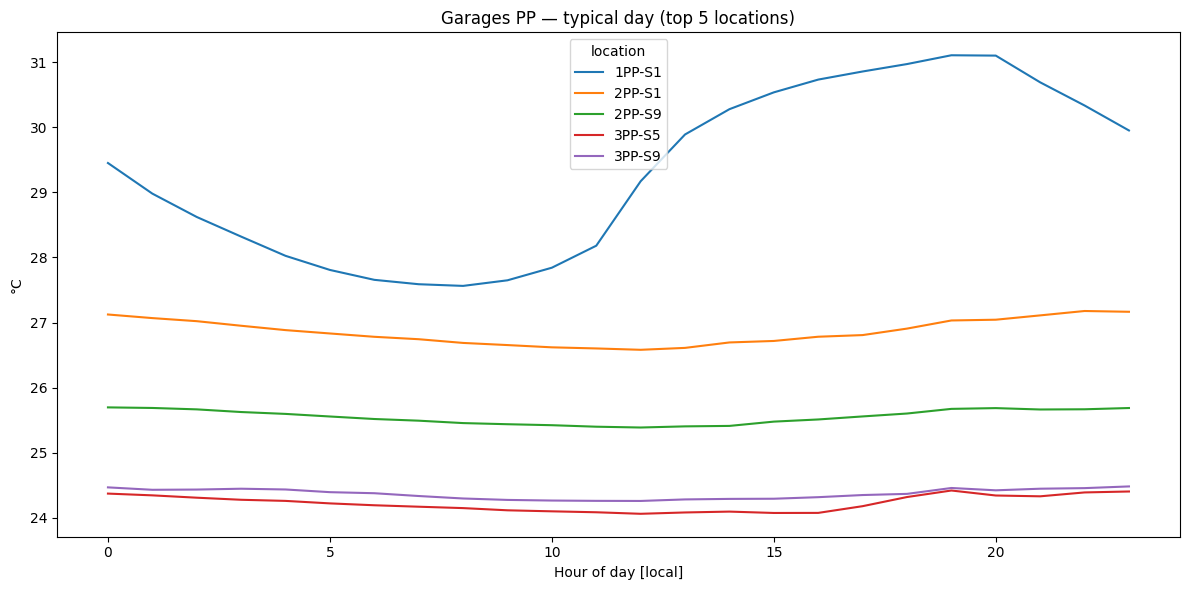

Saved: outputs/profile_garages_top5.png


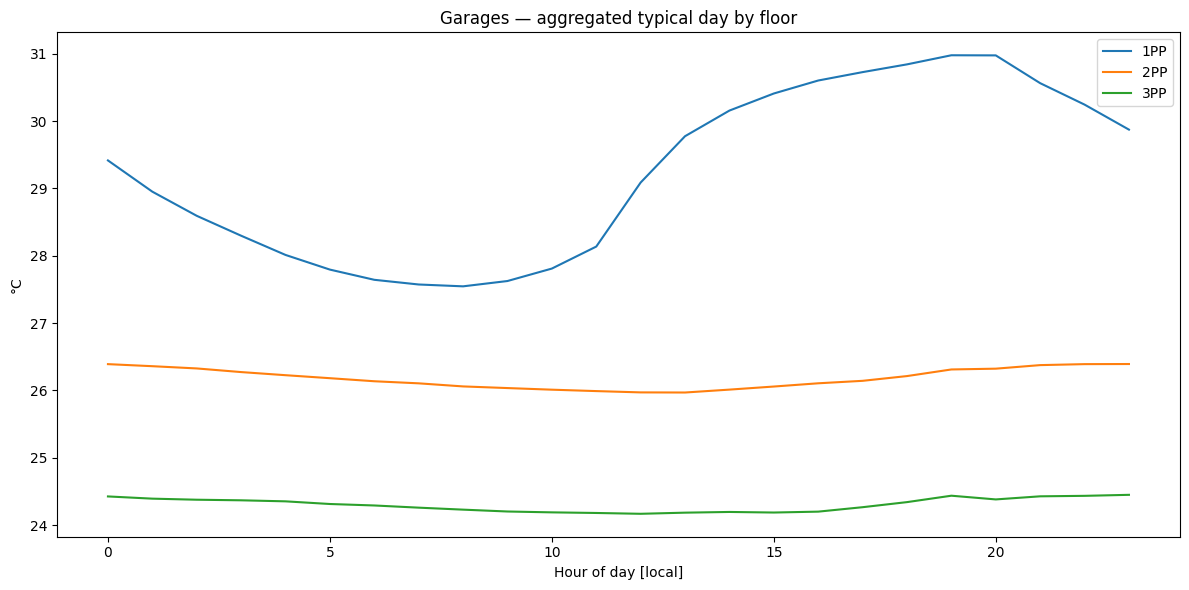

Saved: outputs/profile_garages_by_floor.png


In [6]:
tp_pp = tp_summer[tp_summer['location'].str.contains('PP', na=False)].copy()
if tp_pp.empty:
    print('No PP data to profile.')
else:
    top5 = tp_pp['location'].value_counts().head(5).index.tolist()
    pp_top = tp_pp[tp_pp['location'].isin(top5)].copy()
    hod_top = (pp_top.groupby(['location','hod'])['data_value']
                        .mean()
                        .reset_index())
    piv = hod_top.pivot_table(index='hod', columns='location', values='data_value', aggfunc='mean')
    fig = plt.figure()
    ax = plt.gca()
    piv.plot(ax=ax, legend=True)
    ax.set_title('Garages PP — typical day (top 5 locations)')
    ax.set_xlabel('Hour of day [local]')
    ax.set_ylabel('°C')
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'profile_garages_top5.png', dpi=150)
    plt.show()
    print('Saved:', OUT_DIR / 'profile_garages_top5.png')

    # Aggregated per floor (1PP/2PP/3PP)
    def floor_of(loc):
        m = re.match(r'^(\dPP)-S\d+$', str(loc))
        return m.group(1) if m else None
    tp_pp['floor'] = tp_pp['location'].map(floor_of)
    hod_floor = (tp_pp.groupby(['floor','hod'])['data_value']
                         .mean()
                         .reset_index())
    fig = plt.figure()
    ax = plt.gca()
    for f in ['1PP','2PP','3PP']:
        sub = hod_floor[hod_floor['floor']==f]
        if sub.empty: continue
        ax.plot(sub['hod'], sub['data_value'], label=f)
    ax.set_title('Garages — aggregated typical day by floor')
    ax.set_xlabel('Hour of day [local]')
    ax.set_ylabel('°C')
    ax.legend()
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'profile_garages_by_floor.png', dpi=150)
    plt.show()
    print('Saved:', OUT_DIR / 'profile_garages_by_floor.png')


## Part D — Thermal accumulation / inertia (slow cooling vs outdoor)

We demonstrate that indoor temperatures **accumulate** and **cool slowly**:
- We compare **Atrea `temp_indoor`** daily means with **Atrea `temp_ambient`** daily means.
- We also show **7-day rolling means** to highlight slow dynamics.
- Period: **summer 2025** (Europe/Prague).

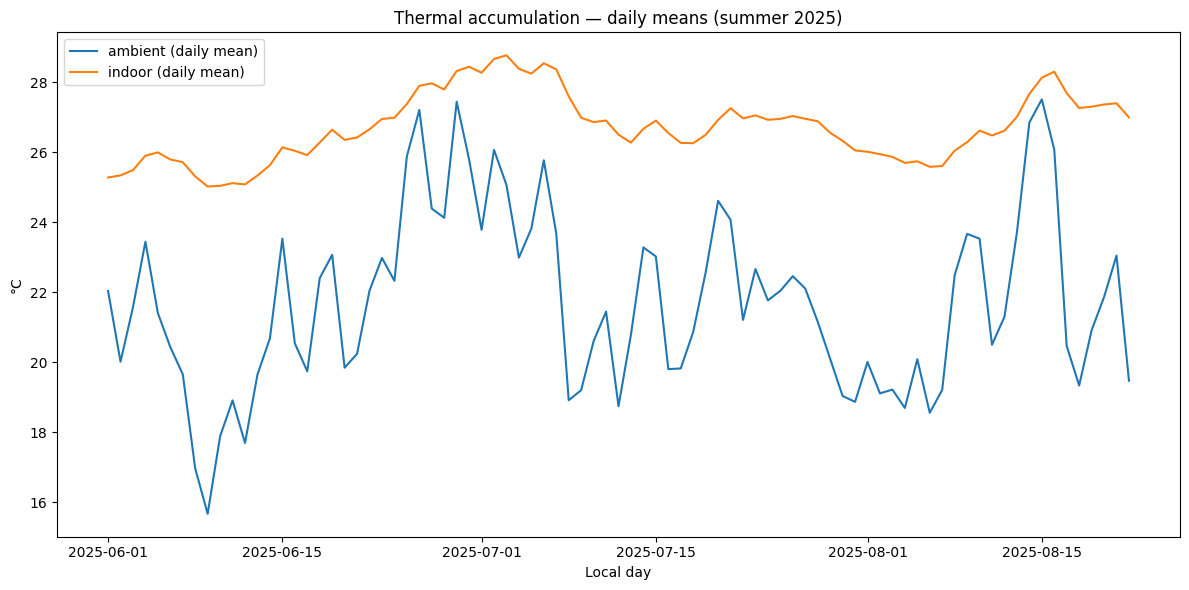

Saved: outputs/accumulation_daily_means_2025.png


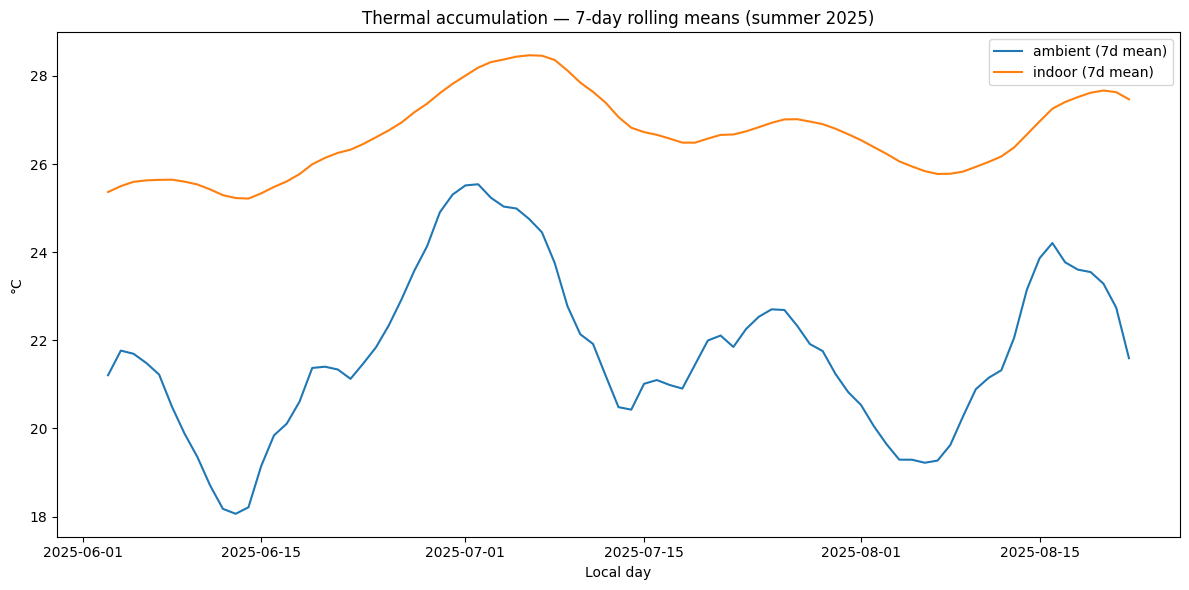

Saved: outputs/accumulation_rolling7_2025.png


In [7]:
atr = atrea.copy()
atr_2025 = atr[(atr['year']==2025) & (atr['local_day']>=SUMMER_START[2025]) & (atr['local_day']<=SUMMER_END[2025])].copy()
if atr_2025.empty:
    print('No Atrea summer 2025 data.')
else:
    # Daily mean across sections
    def daily_mean(frame, key):
        sub = frame[frame['data_key']==key]
        if sub.empty:
            return None
        d = sub.groupby('local_day')['data_value'].mean().reset_index(name=key)
        return d
    d_in = daily_mean(atr_2025, 'temp_indoor')
    d_amb = daily_mean(atr_2025, 'temp_ambient')
    merged = None
    for m in [d_in, d_amb]:
        if m is None: continue
        merged = m if merged is None else pd.merge(merged, m, on='local_day', how='outer')

    if merged is None or merged.empty:
        print('No daily data to plot.')
    else:
        # (1) Daily means overlay
        fig = plt.figure()
        ax = plt.gca()
        if 'temp_ambient' in merged.columns:
            ax.plot(merged['local_day'], merged['temp_ambient'], label='ambient (daily mean)')
        if 'temp_indoor' in merged.columns:
            ax.plot(merged['local_day'], merged['temp_indoor'], label='indoor (daily mean)')
        ax.set_title('Thermal accumulation — daily means (summer 2025)')
        ax.set_xlabel('Local day')
        ax.set_ylabel('°C')
        ax.legend()
        plt.tight_layout()
        plt.savefig(OUT_DIR / 'accumulation_daily_means_2025.png', dpi=150)
        plt.show()
        print('Saved:', OUT_DIR / 'accumulation_daily_means_2025.png')

        # (2) 7-day rolling means
        merged = merged.sort_values('local_day').reset_index(drop=True)
        for col in ['temp_ambient','temp_indoor']:
            if col in merged.columns:
                merged[col+'_roll7'] = merged[col].rolling(window=7, min_periods=3).mean()
        fig = plt.figure()
        ax = plt.gca()
        if 'temp_ambient_roll7' in merged.columns:
            ax.plot(merged['local_day'], merged['temp_ambient_roll7'], label='ambient (7d mean)')
        if 'temp_indoor_roll7' in merged.columns:
            ax.plot(merged['local_day'], merged['temp_indoor_roll7'], label='indoor (7d mean)')
        ax.set_title('Thermal accumulation — 7-day rolling means (summer 2025)')
        ax.set_xlabel('Local day')
        ax.set_ylabel('°C')
        ax.legend()
        plt.tight_layout()
        plt.savefig(OUT_DIR / 'accumulation_rolling7_2025.png', dpi=150)
        plt.show()
        print('Saved:', OUT_DIR / 'accumulation_rolling7_2025.png')


## Interpretation pointers
- **Apartments**: if `temp_indoor` stays elevated throughout the night relative to `temp_ambient` and `temp_fresh`, it indicates **heat retention** and **limited night cooling**.
- **Corridors** (5NP): grouping into cooler/medium/hotter profiles may correlate with **ventilation availability** (e.g., openable windows). Add your metadata to color-code results per section.
- **Garages**: floors likely differ (`1PP` > `2PP` > `3PP`) due to **AC split units** located in 1PP and heat conduction via the concrete skeleton.
- **Accumulation**: **indoor 7-day mean** often lags the **ambient**; even after outdoor cooling, indoor temperatures **decline slowly**.
